In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import numpy as np
import random
from datetime import datetime 

In [75]:
floats_df = pd.read_csv('/Users/elijahflomen/Desktop/Capstone/data/profileData.csv')
sat_df = pd.read_csv('/Users/elijahflomen/Desktop/Capstone/data/satData.csv')

In [76]:
merged_df = sat_df.merge(floats_df, on=['float', "cycleNumber", "date"], how='inner')

In [77]:
sample = merged_df[merged_df["float"] == 1902303]
sample = sample[sample["cycleNumber"] == 75]
sample.date.value_counts()


2022-05-16 01:27:15    490
Name: date, dtype: int64

For each float, what is the avg. amount of time between cycles?

In [78]:
float_cycle_diffs = []
all_floats = list(merged_df.float.unique())

for f in all_floats:
    float_dict = {}
    filtered_float_df = merged_df[merged_df["float"] == f]
    float_dict['float'] = f
    dates = []
    float_cycles = list(filtered_float_df.cycleNumber.unique())
    # for each cycle, look at the date and store in list
    for cycle in float_cycles:
        date_cycle = list(filtered_float_df[filtered_float_df["cycleNumber"]==cycle].date.unique())[0]
        date = datetime.strptime(date_cycle, '%Y-%m-%d %H:%M:%S')
        dates.append(date)
    
    float_dict['dates'] = dates
    float_cycle_diffs.append(float_dict)

for f_dict in float_cycle_diffs:
    dates = f_dict.get('dates')
    f_dict['date_diff'] = [abs(j-i).days for i,j in zip(dates, dates[1:])]


In [79]:
rand_i = random.choice(float_cycle_diffs)

print("Float", rand_i.get('float'))
print("First cycle date", rand_i.get('dates')[0])
print("Second cycle date", rand_i.get('dates')[1])

Float 2902114
First cycle date 2013-11-29 11:27:00
Second cycle date 2013-12-04 11:33:00


In [80]:
# select random float, then plot a dist of its avg. days between cycles
rand_i = random.choice(float_cycle_diffs)
date_diffs = rand_i.get('date_diff')
# print(date_diffs)


In [81]:
cycle_check = merged_df[merged_df["cycleNumber"] == 1]
cycle_check.date.value_counts()

2014-02-19 11:38:00    995
2016-04-19 10:35:00    977
2015-11-06 03:42:00    960
2013-04-18 11:34:00    829
2017-12-05 00:12:57    823
                      ... 
2013-02-23 03:51:00    108
2014-04-06 11:46:00     99
2014-04-04 12:00:00     66
2010-06-01 16:28:06     66
2014-03-10 11:55:59     63
Name: date, Length: 473, dtype: int64

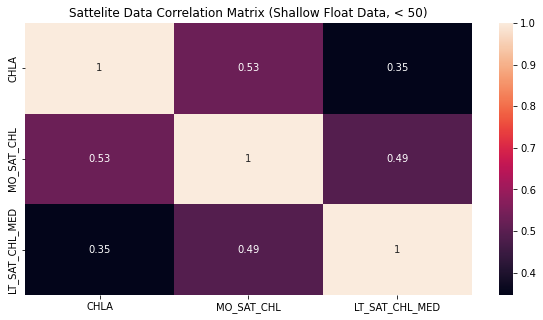

In [82]:
shallow_bucket = merged_df[merged_df["PRES"] <= 50]
fig, ax  = plt.subplots(1,1, figsize=(10,5))
satCorrMatrix = shallow_bucket[["CHLA", "MO_SAT_CHL", "LT_SAT_CHL_MED"]].corr()
ax.set_title("Sattelite Data Correlation Matrix (Shallow Float Data, < 50)")
sns.heatmap(satCorrMatrix, annot=True)
plt.show()

<AxesSubplot:xlabel='MO_SAT_CHL', ylabel='CHLA'>

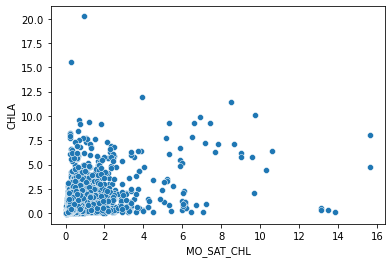

In [83]:
sns.scatterplot(data=shallow_bucket.sample(frac=0.01),x='MO_SAT_CHL', y='CHLA')

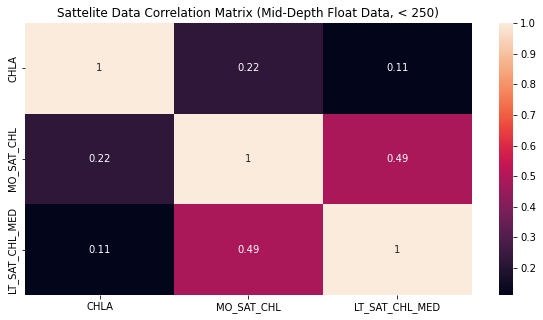

In [84]:
mid_bucket = merged_df[(merged_df["PRES"] <= 250)]
fig, ax  = plt.subplots(1,1, figsize=(10,5))
satCorrMatrix = mid_bucket[["CHLA", "MO_SAT_CHL", "LT_SAT_CHL_MED"]].corr()
ax.set_title("Sattelite Data Correlation Matrix (Mid-Depth Float Data, < 250)")
sns.heatmap(satCorrMatrix, annot=True)
plt.show()

<AxesSubplot:xlabel='MO_SAT_CHL', ylabel='CHLA'>

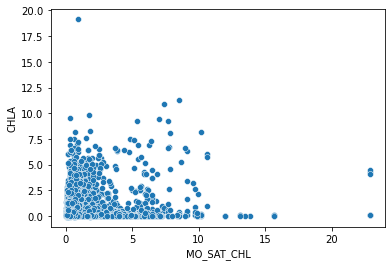

In [85]:
sns.scatterplot(data=mid_bucket.sample(frac=0.01),x='MO_SAT_CHL', y='CHLA')

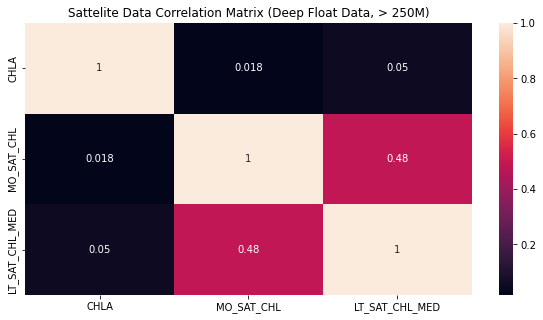

In [86]:
deep_bucket = merged_df[(merged_df["PRES"] > 250)]
fig, ax  = plt.subplots(1,1, figsize=(10,5))
satCorrMatrix = deep_bucket[["CHLA", "MO_SAT_CHL", "LT_SAT_CHL_MED"]].corr()
ax.set_title("Sattelite Data Correlation Matrix (Deep Float Data, > 250M)")
sns.heatmap(satCorrMatrix, annot=True)
plt.show()

<AxesSubplot:xlabel='MO_SAT_CHL', ylabel='CHLA'>

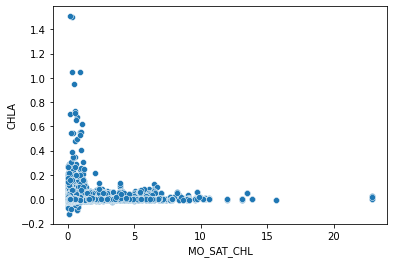

In [87]:
sns.scatterplot(data=deep_bucket.sample(frac=0.01),x='MO_SAT_CHL', y='CHLA')

Hypothesis: Floats in similar geographic areas, at the same seasonality will have similar drop off levels of CHLA. We can test this by looking at clustering floats by their drop off distributions and then see if these floats are located in similar locations and occured at the same time. If so, we could have a model that predicts CHLA at a given depth, given that we know the surface level CHLA level. 

In [88]:
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
labels = [1,2,3,4,5,6, 7,8,9,10]

binned_float_df = merged_df.copy()
binned_float_df['depth_bin'] = pd.cut(binned_float_df['PRES'], bins=bins, labels=labels)
binned_float_df = binned_float_df.groupby(by=["float", "depth_bin"]).mean().reset_index()
binned_float_df = binned_float_df[["latitude", "longitude", "depth_bin", "CHLA"]].dropna()
binned_float_df

,latitude,longitude,depth_bin,CHLA
0,46.198226,-15.822040,1,0.587371
1,46.184097,-15.827439,2,0.057247
2,46.182999,-15.832402,3,0.007237
3,46.169765,-15.859772,4,0.004136
4,46.137074,-15.973315,5,0.003326
...,...,...,...,...
5685,16.917434,-24.011384,6,0.002034
5686,16.918278,-24.023601,7,0.000837
5687,16.915314,-24.016462,8,0.000590
5688,16.924312,-24.005782,9,0.000287


In [89]:
# now, lets group data into LAT LONG bins (say 500)
est = KMeans(n_clusters=500)
lat_long_data = binned_float_df[["latitude", "longitude"]]
groups = est.fit_predict(lat_long_data)
binned_float_df["loc_group"] = groups
binned_float_df


,latitude,longitude,depth_bin,CHLA,loc_group
0,46.198226,-15.822040,1,0.587371,26
1,46.184097,-15.827439,2,0.057247,26
2,46.182999,-15.832402,3,0.007237,26
3,46.169765,-15.859772,4,0.004136,26
4,46.137074,-15.973315,5,0.003326,26
...,...,...,...,...,...
5685,16.917434,-24.011384,6,0.002034,484
5686,16.918278,-24.023601,7,0.000837,484
5687,16.915314,-24.016462,8,0.000590,484
5688,16.924312,-24.005782,9,0.000287,484


In [90]:
locs = list(binned_float_df.loc_group.unique())
depths = []

for l in locs:
    depth_dict = {}
    depth_dict["loc_group"] = l
    filtered_df = binned_float_df[binned_float_df['loc_group'] == l]
    chla_dict = {}
    for i in filtered_df.index:
        chla_val = filtered_df.loc[i, "CHLA"]
        chla_dict[f"{filtered_df.loc[i, 'depth_bin']}"] = chla_val
    
    depth_dict["depths"] = chla_dict
    
    depths.append(depth_dict)
    

In [91]:
data_for_cluster = []

for d_dict in depths:
    cluster_dict =  d_dict.get('depths')
    cluster_dict['loc_group'] = d_dict.get('loc_group')
    data_for_cluster.append(cluster_dict)
    
wide_binned_float_df = pd.DataFrame(data_for_cluster)
cols = list(wide_binned_float_df.columns)
cols = [cols[-1]] + cols[:-1]
wide_binned_float_df = wide_binned_float_df[cols]
wide_binned_float_df = wide_binned_float_df.dropna()
wide_binned_float_df

,loc_group,1,2,3,4,5,6,7,8,9,10
0,26,0.587371,0.057247,0.007237,0.004136,0.003326,0.003689,0.004410,0.005358,0.005545,0.005412
1,390,0.613906,0.042689,0.005194,0.002628,0.001119,0.001198,0.001574,0.001962,0.003538,0.004413
2,304,0.073780,0.138327,0.002982,0.004663,0.006797,0.006543,0.006098,0.005857,0.005639,0.005181
3,253,0.131331,0.098308,0.003915,0.006476,0.006754,0.006287,0.006101,0.006182,0.005774,0.005294
4,203,0.155070,0.068712,0.005833,0.009935,0.011098,0.010176,0.009418,0.008812,0.008345,0.008079
...,...,...,...,...,...,...,...,...,...,...,...
495,16,0.211404,0.049287,0.031562,0.017866,0.010677,0.007499,0.005891,0.006562,0.042029,0.059386
496,171,0.230045,0.004649,0.004209,0.005639,0.005402,0.004415,0.003939,0.002285,0.001788,0.000964
497,58,0.169882,0.031290,-0.007154,-0.007039,-0.006191,-0.006336,-0.006880,-0.006044,-0.006544,-0.006205
498,86,0.238335,0.027766,0.005329,0.000999,0.000495,0.000189,-0.000159,-0.000242,-0.000312,-0.000536


In [92]:
est = KMeans(n_clusters=20)
groups = est.fit_predict(wide_binned_float_df.drop(columns='loc_group'))
wide_binned_float_df["dist_group"] = groups

In [93]:
wide_binned_float_df.sort_values(by='loc_group')
wide_binned_float_df.to_excel("location_CHLA_drop_relationship.xlsx")  


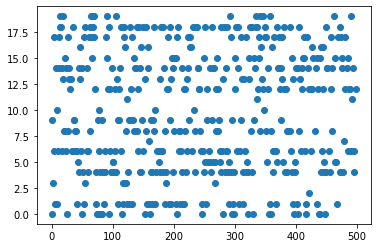

In [94]:
# now lets see if there is a correlation between loc_group and dist_group
plt.scatter(x=wide_binned_float_df['loc_group'], y=wide_binned_float_df['dist_group'])



Does not appear to be any sort of discernable relationship between the CHLA distribution and the location group

In [95]:
grouped_dist_data = wide_binned_float_df.groupby(by='dist_group').mean().reset_index()[["dist_group", 'loc_group']]
grouped_dist_data

,dist_group,loc_group
0,0,230.629630
1,1,213.942857
2,2,422.000000
3,3,125.000000
4,4,243.604167
5,5,288.473684
6,6,221.458333
7,7,319.500000
8,8,226.933333
9,9,174.363636
